In [2]:
import sys
sys.executable

'c:\\Users\\carlo\\miniforge3\\envs\\dtu02452\\python.exe'

In [3]:
from pathlib import Path
import pandas as pd
import mne
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
import pyedflib
from mne.time_frequency import psd_array_welch


In [34]:
data = Path(r"C:\Users\carlo\OneDrive - Universidade de Lisboa\Documents\GitHub\heart-lung-brain-coupling-for-RBD\Data\cap-sleep-database-1.0.0\n3.edf")
raw = mne.io.read_raw_edf(data, preload=False, verbose=False)
raw.load_data()

raw.info["sfreq"], len(raw.ch_names), raw.ch_names[:10]

Reading 0 ... 16927231  =      0.000 ... 33060.998 secs...


C:\Users\carlo\AppData\Local\Temp\ipykernel_25604\1649241192.py:2: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data, preload=False, verbose=False)
C:\Users\carlo\AppData\Local\Temp\ipykernel_25604\1649241192.py:2: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(data, preload=False, verbose=False)


(512.0,
 23,
 ['Fp2-F4',
  'F4-C4',
  'C4-P4',
  'P4-O2',
  'F8-T4',
  'T4-T6',
  'FP1-F3',
  'F3-C3',
  'C3-P3',
  'P3-O1'])

In [37]:
print("Sampling frequency:", raw.info["sfreq"])
print("Duration (s):", raw.n_times / raw.info["sfreq"])

Sampling frequency: 512.0
Duration (s): 33061.0


In [38]:
txt_path = r"C:\Users\carlo\OneDrive - Universidade de Lisboa\Documents\GitHub\heart-lung-brain-coupling-for-RBD\Data\cap-sleep-database-1.0.0\rbd1.txt"
df = pd.read_csv(txt_path, sep='\t', header=None, names=["Sleep Stage", "Position", "Time [hh:mm:ss]", "Event", "Duration[s]", "Location"], skiprows=22)
df.head()

,Sleep Stage,Position,Time [hh:mm:ss],Event,Duration[s],Location
0,W,Unknown Position,23:07:19,SLEEP-S0,30,ROC-LOC
1,W,Unknown Position,23:07:49,SLEEP-S0,30,ROC-LOC
2,W,Unknown Position,23:08:19,SLEEP-S0,30,ROC-LOC
3,W,Unknown Position,23:08:49,SLEEP-S0,30,ROC-LOC
4,W,Unknown Position,23:09:19,SLEEP-S0,30,ROC-LOC


In [68]:
import importlib
import functions
importlib.reload(functions)

from functions import compute_stage_epochs, add_epoch_onsets

df = add_epoch_onsets(df, 30.0)

stages = ["W", "R", "S1", "S2", "S3", "S4"]

stage_dfs = {}

for stage in stages:
    stage_dfs[stage] = compute_stage_epochs(df, stage)

stage_dfs["R"][:5]

[(13620.0, 13650.0),
 (13650.0, 13680.0),
 (13680.0, 13710.0),
 (13710.0, 13740.0),
 (13740.0, 13770.0)]

In [69]:
rem_epochs = compute_stage_epochs(df, "R")

rem_df = pd.DataFrame(rem_epochs, columns=["t0", "t1"])
rem_df["duration"] = rem_df["t1"] - rem_df["t0"]

display(rem_df.head())

,t0,t1,duration
0,13620.0,13650.0,30.0
1,13650.0,13680.0,30.0
2,13680.0,13710.0,30.0
3,13710.0,13740.0,30.0
4,13740.0,13770.0,30.0


In [84]:
wake_epochs = compute_stage_epochs(df, "W")
rem_epochs  = compute_stage_epochs(df, "R")
S1_epochs   = compute_stage_epochs(df, "S1")
S2_epochs   = compute_stage_epochs(df, "S2")
S3_epochs   = compute_stage_epochs(df, "S3")
S4_epochs   = compute_stage_epochs(df, "S4")

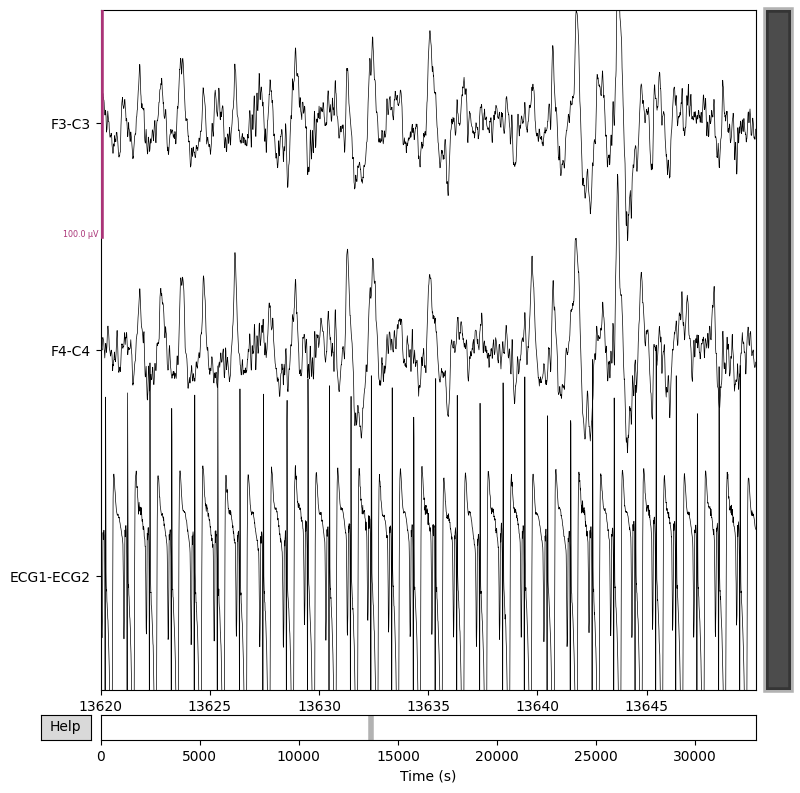

In [85]:
from functions import pick_core_channels
raw_core = pick_core_channels(raw)

fig = raw_core.plot(
    start=float(t0),
    duration=30.0,
    picks=raw_core.ch_names,
    scalings=dict(eeg=50e-6, ecg=1e-3),
    title="First REM epoch (30s)",
    show=True
)

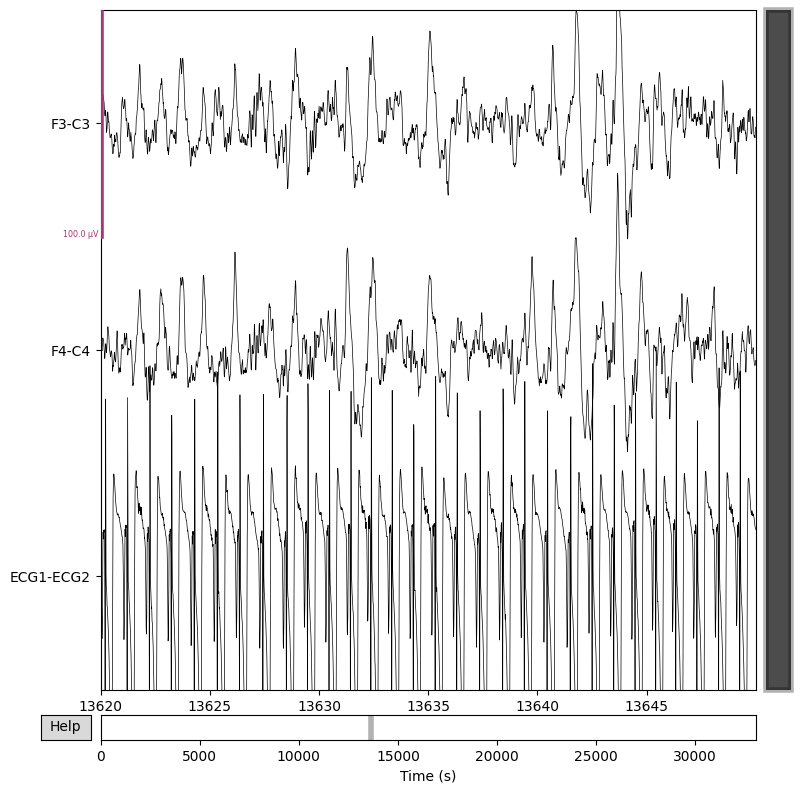

In [86]:
# Filter EEG 
import importlib
import functions
importlib.reload(functions)
from functions import preprocess_eeg

eeg_filtered = preprocess_eeg(raw_core)
fig = eeg_filtered.plot(start=float(t0),duration=30.0, scalings=dict(eeg=50e-6, ecg=1e-3), title="EEG — FILTERED", show=True)

Effective window size : 0.500 (s)
Effective window size : 0.500 (s)


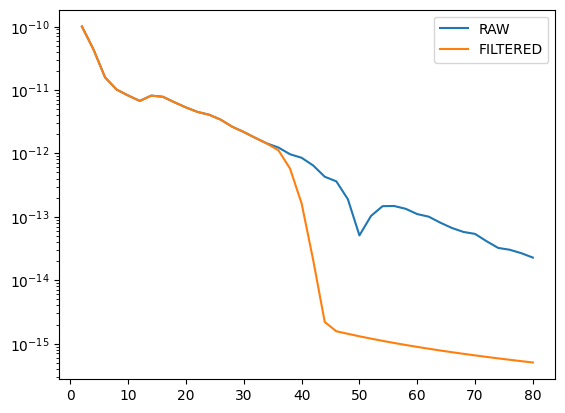

In [87]:
X_raw = raw_core.get_data()
X_filt = eeg_filtered.get_data()
sf = raw_core.info["sfreq"]

psd_raw, freqs = psd_array_welch(X_raw, sf, fmin=0.5, fmax=80)
psd_filt, _ = psd_array_welch(X_filt, sf, fmin=0.5, fmax=80)

plt.semilogy(freqs, psd_raw.mean(axis=0), label="RAW")
plt.semilogy(freqs, psd_filt.mean(axis=0), label="FILTERED")
plt.legend()
plt.show()

F3-C3: 1.02e-12 ± 4.05e-12 µV²/Hz
F3-C3: 1.02e-12 ± 4.04e-12 µV²/Hz
F4-C4: 1.21e-12 ± 4.74e-12 µV²/Hz
F4-C4: 1.21e-12 ± 4.73e-12 µV²/Hz
ECG1-ECG2: 5.05e-11 ± 1.44e-10 µV²/Hz
ECG1-ECG2: 5.02e-11 ± 1.44e-10 µV²/Hz


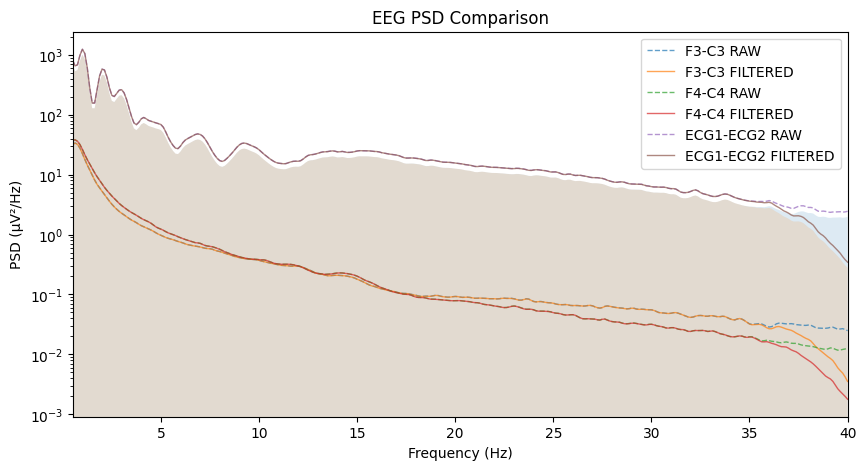

In [88]:
import importlib
import functions
importlib.reload(functions)

from functions import plot_psd_comparison, compute_psd, summarize_psd

psd_raw, freqs = compute_psd(raw_core)
psd_filt, _ = compute_psd(eeg_filtered)

summarize_psd(psd_raw, psd_filt, raw_core.ch_names)

plot_psd_comparison(freqs, psd_raw, psd_filt, raw_core.ch_names)

In [91]:
import importlib
import functions
importlib.reload(functions)

from functions import eeg_bandpower_per_epoch, eeg_bandpower_all_stages

stage_epochs = {"W": wake_epochs, "R": rem_epochs, "S1": S1_epochs, "S2": S2_epochs, "S3": S3_epochs, "S4": S4_epochs}
eeg_stage_df = eeg_bandpower_all_stages(eeg_filtered, stage_epochs)

for stage in eeg_stage_df["stage"].unique():
    print(f"\nBandpower table for stage {stage} (first 5 rows):")
    display(eeg_stage_df[eeg_stage_df["stage"] == stage].head(5))



Bandpower table for stage W (first 5 rows):


,epoch,start_s,delta_power,theta_power,alpha_power,beta_power,gamma_power,stage
0,0,0.0,4.009712e-10,2.468272e-10,1.304033e-10,3.242897e-10,2.455019e-11,W
1,1,30.0,4.146743e-10,2.927971e-10,1.709307e-10,4.513445e-10,6.179885e-11,W
2,2,60.0,4.071017e-10,2.784723e-10,1.405602e-10,3.215697e-10,3.033304e-11,W
3,3,90.0,3.165966e-10,2.105760e-10,1.531139e-10,3.942270e-10,4.280175e-11,W
4,4,120.0,3.225244e-10,2.109463e-10,1.485389e-10,3.539513e-10,3.593189e-11,W



Bandpower table for stage R (first 5 rows):


,epoch,start_s,delta_power,theta_power,alpha_power,beta_power,gamma_power,stage
72,0,13620.0,2.140896e-10,1.399701e-10,2.789923e-11,5.106268e-11,2.077285e-12,R
73,1,13650.0,1.417316e-10,8.031745e-11,2.342592e-11,5.946018e-11,2.279082e-12,R
74,2,13680.0,1.276728e-10,7.121903e-11,2.922198e-11,7.878518e-11,3.093817e-12,R
75,3,13710.0,1.725790e-10,1.073412e-10,2.627761e-11,5.774673e-11,2.265027e-12,R
76,4,13740.0,1.772525e-10,1.111502e-10,2.530809e-11,4.998967e-11,1.861584e-12,R



Bandpower table for stage S1 (first 5 rows):


,epoch,start_s,delta_power,theta_power,alpha_power,beta_power,gamma_power,stage
198,0,690.0,3.783229e-10,2.752682e-10,1.003411e-10,2.271934e-10,1.161459e-11,S1
199,1,720.0,3.841323e-10,2.830674e-10,1.006830e-10,2.300658e-10,1.134297e-11,S1
200,2,750.0,3.828062e-10,2.811973e-10,1.053264e-10,2.445908e-10,1.540428e-11,S1
201,3,780.0,4.726716e-10,3.465593e-10,1.836992e-10,3.376575e-10,2.601708e-11,S1
202,4,1170.0,3.487267e-10,2.439757e-10,9.933630e-11,2.650610e-10,3.125190e-11,S1



Bandpower table for stage S2 (first 5 rows):


,epoch,start_s,delta_power,theta_power,alpha_power,beta_power,gamma_power,stage
250,0,810.0,3.567756e-10,2.555492e-10,9.895591e-11,2.052401e-10,8.976983e-12,S2
251,1,840.0,3.468994e-10,2.477937e-10,9.363283e-11,1.949732e-10,1.447215e-11,S2
252,2,870.0,3.637727e-10,2.682124e-10,9.894326e-11,2.435193e-10,1.202359e-11,S2
253,3,900.0,3.729058e-10,2.638270e-10,8.772384e-11,1.875036e-10,7.701873e-12,S2
254,4,930.0,3.628755e-10,2.571031e-10,1.057367e-10,2.335889e-10,8.890834e-12,S2



Bandpower table for stage S3 (first 5 rows):


,epoch,start_s,delta_power,theta_power,alpha_power,beta_power,gamma_power,stage
722,0,1560.0,4.097014e-10,2.862359e-10,7.555702e-11,1.778659e-10,1.136318e-11,S3
723,1,1590.0,3.441904e-10,2.316385e-10,7.822408e-11,1.849235e-10,1.093960e-11,S3
724,2,1620.0,3.769905e-10,2.560534e-10,6.856242e-11,1.356105e-10,4.934933e-12,S3
725,3,1650.0,3.216367e-10,2.334823e-10,7.941573e-11,1.790955e-10,7.188161e-12,S3
726,4,1680.0,3.249851e-10,2.135658e-10,6.589195e-11,1.369106e-10,5.264676e-12,S3



Bandpower table for stage S4 (first 5 rows):


,epoch,start_s,delta_power,theta_power,alpha_power,beta_power,gamma_power,stage
783,0,1890.0,3.271466e-10,2.207107e-10,8.191157e-11,1.783074e-10,8.125354e-12,S4
784,1,1920.0,3.354969e-10,2.226935e-10,8.111208e-11,1.804324e-10,1.353635e-11,S4
785,2,1950.0,3.571107e-10,2.402126e-10,8.238173e-11,1.944304e-10,1.630861e-11,S4
786,3,1980.0,2.787872e-10,1.820161e-10,7.832143e-11,1.778446e-10,6.613530e-12,S4
787,4,2010.0,3.311825e-10,2.239251e-10,7.828400e-11,1.686717e-10,6.147083e-12,S4
